# May Mobility (Data Scientist)

## ToC

## Route of Cars

Rough Idea of how the route looks   

I don't know if this is the actual route.

As I comb through more of the data, I'll get a better understanding of what order the stops are.

I just ploted the lat/lon in order from the appendix to give myself a visual aid.

![rough_image](resources/pics/rough_idea_route.png)

Point of Interest (PoI) Table

| Stop       | Description                      | Latitude | Longitude |
|:-----------|:--------------------------------:|----------|-----------|
| Bus        | Bus stop on a major transit line | 39.77285 | -86.16168 |
| Dentist    | School of Dentistry              | 39.77467 | -86.17895 |
| Doctor     | Pediatrician’s office            | 39.77926 | -86.17496 |
| Admin      | Administrative building          | 39.77459 | -86.17433 |
| Hospital   | Campus hospital                  | 39.77567 | -86.17557 |
| Lime       | Bus stop on campus               | 39.77473 | -86.18376 |
| Parking    | Campus parking lot               | 39.77882 | -86.18121 |
| School     | School of Art and Design         | 39.77148 | -86.17148 |
| University | University lecture hall          | 39.77271 | -86.17575 |


# Read Data and Import modules

In [474]:
%matplotlib inline
# Arrays and DataFrames
import pandas as pd
import numpy as np

# Time baby!
from datetime import datetime

# Plotters
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns

# Extra Stats
import scipy as sp
import scipy.stats as stats

# Machine Learning
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVC

# Machine Learning Stats
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix

# QoL for viewing df output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

# read-in *.csv files
pickups_df   = pd.read_csv("resources/csv/Data_Science_pickups.csv", na_values = np.nan)
ridership_df = pd.read_csv("resources/csv/Data_Science_site_ridership.csv", na_values = np.nan)

# Data Wrangling

## Preliminary Data Checking

##### Converted Variables per *`*.csv`*

<table>
<tr><th>Pickup Data Types </th><th>Ridership Data Types</th></tr>
<tr><td>

| Var         |       Before  |       After     |
|:------------|:--------------|:----------------|
|row_id       | int64         | int64           |
|timestamp    | object        | datetime64[ns]  |   
|pickup       | int64         | int64           |
|dropoff      | int64         | int64           |
|stop         | object        | category        |
|vehicle      | object        | category        |
|time         | object        | object          |
|date         | object        | datetime64[ns]  |
|month        |               | category        |   
|day          |               | category        |   
|hour         |               | category        |   
|name         | object        | category        |

</td><td>

| Var         |       Before  |       After    |
|:------------|:--------------|:---------------|
|timestamp    | object        | datetime64[ns] |
|pickup       | float64       | int64          |
|dropoff      | float64       | int64          |
|stop         | object        | category       |
|vehicle      | object        | category       |
|time         | object        | object         |
|date         | object        | datetime64[ns] |
|month        |               | category       |   
|day          |               | category       |
|hour         |               | category       |   
|name         | object        | category       |

</td></tr> </table>

### Pickups DataFrame

`Data_Science_pickups.csv` File Insight

In [475]:
# get a feel of what the pickups dataframe looks like
pickups_df.head()

,row_id,timestamp,pickup,dropoff,stop,vehicle,time,date,name
0,1,2021-11-01 07:10:54,1,0,Bus,Marble,07:00:00,2021-11-01,ES
1,2,2021-11-01 07:51:13,1,0,Bus,Marble,07:50:00,2021-11-01,ES
2,3,2021-11-01 08:02:13,1,0,Lime,Marble,08:01:00,2021-11-01,ES
3,4,2021-11-01 08:41:16,1,0,Doctor,Motto,08:41:00,2021-11-01,CM
4,5,2021-11-01 09:24:10,1,0,Bus,Myao,09:22:00,2021-11-01,CM


Initial Data Types

In [476]:
# pickups data frame: data types
pickups_df.dtypes

row_id        int64
timestamp    object
pickup        int64
dropoff       int64
stop         object
vehicle      object
time         object
date         object
name         object
dtype: object

Null Check

In [477]:
# pickups data frame: check for nulls and count
pickups_df.isnull().sum()

row_id       0
timestamp    0
pickup       0
dropoff      0
stop         0
vehicle      0
time         0
date         0
name         0
dtype: int64

Convert Vars

In [478]:
# pickups data frame: Update Data types

# timestamp    object
pickups_df["timestamp"] = pd.to_datetime(pickups_df["timestamp"], format="%Y-%m-%d %H:%M:%S")

# stop         object
pickups_df["stop"] = pickups_df["stop"].astype("category")

# vehicle      object
pickups_df["vehicle"] = pickups_df["vehicle"].astype("category")

# date         object
pickups_df["date"] = pd.to_datetime(pickups_df["date"], format="%Y-%m-%d")

# name         object
pickups_df["name"] = pickups_df["name"].astype("category")

pickups_df.dtypes

row_id                int64
timestamp    datetime64[ns]
pickup                int64
dropoff               int64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
name               category
dtype: object

Collection Date Range

In [479]:
# check record dates
pickup_timestamp_min = pickups_df["timestamp"].min()
pickup_timestamp_max = pickups_df["timestamp"].max()

print(f'The range of dates: {pickup_timestamp_min:%b %d %Y} to {pickup_timestamp_max:%b %d %Y}.')

The range of dates: Nov 01 2021 to Nov 12 2021.


Entries per Vehicle

In [480]:
# check count records per vehicle 
pickups_df["timestamp"].groupby(pickups_df["vehicle"]).count()

vehicle
Marble    91
Mette     26
Moon      58
Motto     99
Myao      89
Name: timestamp, dtype: int64

Entries per Name

In [481]:
pickups_df["timestamp"].groupby(pickups_df["name"]).count().sort_values(ascending=False)

name
CM    138
JR    127
VG     28
TL     26
DL     11
ES      8
DN      7
MV      7
KP      6
SR      5
Name: timestamp, dtype: int64

Entries per stop

In [482]:
pickups_df["timestamp"].groupby(pickups_df["stop"]).count().sort_values(ascending=False)

stop
Bus           97
Lime          95
Doctor        44
University    38
Admin         35
Hospital      20
Dentist       19
School        14
Parking        1
Name: timestamp, dtype: int64

### Ridership DataFrame

`Data_Science_site_ridership.csv` File Insight

In [483]:
# get a feel of what the pickups dataframe looks like
ridership_df.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,name
0,2021-06-03 13:08:10,1.00,0.00,Bus,Motto,13:05:00,2021-06-03,JR
1,2021-06-03 13:31:41,0.00,1.00,Bus,Motto,13:31:43,2021-06-03,JR
2,2021-06-04 11:06:02,1.00,0.00,School,Motto,11:03:00,2021-06-04,CM
3,2021-06-04 11:07:48,0.00,1.00,Bus,Motto,11:07:00,2021-06-04,CM
4,2021-06-04 12:43:54,1.00,0.00,Bus,Motto,12:40:00,2021-06-04,MN


Initial Data Types

In [484]:
# ridership data frame: data types
ridership_df.dtypes

timestamp     object
pickup       float64
dropoff      float64
stop          object
vehicle       object
time          object
date          object
name          object
dtype: object

Null Check

In [485]:
# ridership data frame: check for nulls and count
ridership_df.isnull().sum()

timestamp     0
pickup       12
dropoff      15
stop          0
vehicle       0
time          0
date          0
name          0
dtype: int64

Convert Vars

In [486]:
# Data type changes in ridership_df
# timestamp     object
ridership_df["timestamp"] = pd.to_datetime(ridership_df["timestamp"], format="%Y-%m-%d %H:%M:%S")

# # pickup       float64 
# Should be int64
# ridership_df["pickup"] = ridership_df["pickup"]

# # dropoff      float64
# Should be int64
# ridership_df["dropoff"] = ridership_df["dropoff"]

# stop          object
ridership_df["stop"] = ridership_df["stop"].astype("category")

# vehicle       object
ridership_df["vehicle"] = ridership_df["vehicle"].astype("category")

# date          object
ridership_df["date"] = pd.to_datetime(ridership_df["date"], format="%Y-%m-%d")

# name          object
ridership_df["name"] = ridership_df["name"].astype("category")

ridership_df.dtypes

timestamp    datetime64[ns]
pickup              float64
dropoff             float64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
name               category
dtype: object

Data Collected

In [555]:
# check record dates
pickup_timestamp_min = ridership_df["timestamp"].min()
pickup_timestamp_max = ridership_df["timestamp"].max()

print(f'The range of dates: {pickup_timestamp_min:%b %d %Y} to {pickup_timestamp_max:%b %d %Y}.')

The range of dates: Jun 03 2021 to Oct 29 2021.


### Ridership DataFrame: Investage and Fix

#### Months, Days, and Hours Strip

Months

In [487]:
# add Months for QoL
ridership_df.insert(ridership_df.columns.get_loc("name"),"month",ridership_df["timestamp"].dt.month_name().astype("category"))

Days

In [488]:
# add days of the week for QoL
day_number = ridership_df["timestamp"].dt.weekday
day_name   = ridership_df["timestamp"].dt.day_name()
weekend    = day_number > 5 # is weekend?

if ~any(weekend):
    print(f"since any(weekend) = {any(weekend)}, There are no rides on the weekends.")
else:
    print(f"since any(weekend) = {any(weekend)}, There are rides on the weekends.")

# nice to check side-by-side, don't really need this next line.
op_days = pd.DataFrame({"day_num":day_number,"day":day_name,"is_weekday":weekend}) 

ridership_df.insert(ridership_df.columns.get_loc("name"),"day",ridership_df["timestamp"].dt.day_name().astype("category"))

since any(weekend) = False, There are no rides on the weekends.


Hours

In [489]:
# add hours for QoL
ridership_df.insert(ridership_df.columns.get_loc("name"),"hour",ridership_df["timestamp"].dt.hour.astype("category"))

Modify Categorical Data to be Ordered

In [490]:
# order days and months for categorical data
months_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ridership_df["month"] = pd.Categorical(ridership_df["month"], categories=months_ordered, ordered=True)
ridership_df["day"]   = pd.Categorical(ridership_df["day"], categories=days_ordered, ordered=True)
ridership_df["hour"]  = pd.Categorical(ridership_df["hour"], ordered=True)

In [491]:
# nice columns
ridership_df.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
0,2021-06-03 13:08:10,1.00,0.00,Bus,Motto,13:05:00,2021-06-03,June,Thursday,13,JR
1,2021-06-03 13:31:41,0.00,1.00,Bus,Motto,13:31:43,2021-06-03,June,Thursday,13,JR
2,2021-06-04 11:06:02,1.00,0.00,School,Motto,11:03:00,2021-06-04,June,Friday,11,CM
3,2021-06-04 11:07:48,0.00,1.00,Bus,Motto,11:07:00,2021-06-04,June,Friday,11,CM
4,2021-06-04 12:43:54,1.00,0.00,Bus,Motto,12:40:00,2021-06-04,June,Friday,12,MN


#### Error/Null/NaN Inspection and Fixing 

Days of the Week Count for Pickup and Dropoff

In [492]:
# days of the week stats
ridership_stats_days = ridership_df[["pickup","dropoff"]].groupby(ridership_df["day"]).describe().dropna()
ridership_stats_days

pickup                                     dropoff                                   
             count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
day                                                                                              
Monday      716.00 0.60 0.66 0.00 0.00 1.00 1.00 3.00   715.00 0.61 0.65 0.00 0.00 1.00 1.00 3.00
Tuesday     817.00 0.61 0.70 0.00 0.00 1.00 1.00 4.00   815.00 0.61 0.69 0.00 0.00 1.00 1.00 4.00
Wednesday   874.00 0.63 0.79 0.00 0.00 1.00 1.00 8.00   874.00 0.62 0.77 0.00 0.00 1.00 1.00 8.00
Thursday  1,003.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00 1,003.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
Friday      930.00 0.64 0.75 0.00 0.00 1.00 1.00 4.00   930.00 0.65 0.73 0.00 0.00 1.00 1.00 3.00

##### Null Fixing

Ridership Pickup

In [493]:
# inspect missing data from pickups
null_ridership_pickup = ridership_df[ridership_df["pickup"].isnull()]
null_ridership_pickup

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
79,2021-06-17 14:09:37,NaN,1.00,Hospital,Mette,14:06:00,2021-06-17,June,Thursday,14,MV
81,2021-06-17 16:52:03,NaN,1.00,Doctor,Motto,16:51:00,2021-06-17,June,Thursday,16,JR
83,2021-06-17 20:25:00,NaN,1.00,Bus,Mette,17:03:00,2021-06-17,June,Thursday,20,JR
85,2021-06-18 11:23:45,NaN,1.00,Parking,Myao,11:16:00,2021-06-18,June,Friday,11,CM
87,2021-06-18 14:16:28,NaN,1.00,School,Mette,14:16:00,2021-06-18,June,Friday,14,MN
89,2021-06-18 17:08:13,NaN,1.00,University,Motto,17:07:00,2021-06-18,June,Friday,17,JR
91,2021-06-21 11:50:34,NaN,1.00,University,Myao,11:49:00,2021-06-21,June,Monday,11,CM
93,2021-06-21 11:51:33,NaN,1.00,Bus,Mette,09:15:00,2021-06-21,June,Monday,11,CM
95,2021-06-21 11:52:30,NaN,1.00,Bus,Mette,09:39:00,2021-06-21,June,Monday,11,CM
97,2021-06-21 11:53:31,NaN,1.00,Doctor,Myao,10:33:00,2021-06-21,June,Monday,11,CM


Ridership Dropoff

In [494]:
# inspect missing data from pickups
null_ridership_dropoff = ridership_df[ridership_df["dropoff"].isnull()]
null_ridership_dropoff

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
78,2021-06-17 14:02:53,1.00,NaN,Lime,Mette,14:00:00,2021-06-17,June,Thursday,14,MV
80,2021-06-17 16:49:04,1.00,NaN,Bus,Motto,16:40:00,2021-06-17,June,Thursday,16,JR
82,2021-06-17 16:53:10,1.00,NaN,Doctor,Mette,16:52:00,2021-06-17,June,Thursday,16,JR
84,2021-06-18 11:05:49,1.00,NaN,Bus,Myao,11:05:00,2021-06-18,June,Friday,11,CM
86,2021-06-18 14:12:59,1.00,NaN,Lime,Mette,14:10:00,2021-06-18,June,Friday,14,MN
88,2021-06-18 17:05:47,1.00,NaN,Doctor,Motto,17:04:00,2021-06-18,June,Friday,17,JR
90,2021-06-21 11:26:12,1.00,NaN,University,Myao,11:25:00,2021-06-21,June,Monday,11,CM
92,2021-06-21 11:51:08,1.00,NaN,Lime,Mette,08:56:00,2021-06-21,June,Monday,11,CM
94,2021-06-21 11:52:02,1.00,NaN,Doctor,Mette,09:29:00,2021-06-21,June,Monday,11,CM
96,2021-06-21 11:53:04,1.00,NaN,Bus,Myao,10:21:00,2021-06-21,June,Monday,11,CM


##### Error Fixing

Find Questionable Data

In [495]:
# find data that shows pickup and/or dropoffs > 4
entry_error_ridership_df = ridership_df[(ridership_df[["pickup","dropoff"]] > 4).any(axis=1)]
entry_error_ridership_df

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
346,2021-07-14 16:45:21,8.00,0.00,Parking,Myao,16:44:00,2021-07-14,July,Wednesday,16,LA
348,2021-07-14 16:58:55,0.00,8.00,Admin,Myao,16:54:00,2021-07-14,July,Wednesday,16,LA
456,2021-07-21 14:18:18,8.00,0.00,Admin,Mette,14:18:00,2021-07-21,July,Wednesday,14,CM
457,2021-07-21 14:19:58,0.00,8.00,University,Mette,14:19:00,2021-07-21,July,Wednesday,14,CM


Who Made These Errors and Frequency

In [496]:
# input errors per person
entry_error = entry_error_ridership_df["name"].groupby(entry_error_ridership_df["name"]).count()
entry_error[entry_error > 0]

name
CM    2
LA    2
Name: name, dtype: int64

#### Total Error/Null Errors

 High Level Breakdown

In [550]:
# display data analytics of errors/nulls/missing

# investigate nulls and errors from earlier
# 
# pickup       12
# dropoff      15
# input errors  4

total_records = ridership_df.shape[0] # total records

null_pickup_count  = ridership_df["pickup"].isnull().sum() # null count pickup
null_dropoff_count = ridership_df["dropoff"].isnull().sum() # null count dropoff
total_null_count   = null_pickup_count + null_dropoff_count # sum of null count

entry_error_count  = entry_error_ridership_df.shape[0] # error entries
total_error_count  = total_null_count + entry_error_count # grand total errors

print(f"Missing pickup data:  {null_pickup_count:3.0f} out of {total_records} records, {null_pickup_count/total_records:.2%}.")
print(f"Missing dropoff data: {null_dropoff_count:3.0f} out of {total_records} records, {null_dropoff_count/total_records:.2%}.")
print(f"Total null data:      {total_null_count:3.0f} out of {total_records} records, {total_null_count/total_records:.2%}.")
print(f"Entry error data:     {entry_error_count:3.0f} out of {total_records} records, {entry_error_count/total_records:.2%}.")
print(f"Total errors are:     {total_error_count:3.0f} out of {total_records} records, {total_error_count/total_records:.2%}.")

Missing pickup data:   12 out of 4352 records, 0.28%.
Missing dropoff data:  15 out of 4352 records, 0.34%.
Total null data:       27 out of 4352 records, 0.62%.
Entry error data:       4 out of 4352 records, 0.09%.
Total errors are:      31 out of 4352 records, 0.71%.


Error Data per Person

In [498]:
# investigate errors/nulls/missing data.
record_counts_per = ridership_df["name"].value_counts()
total_null_per =  ridership_df[["pickup","dropoff"]].isnull().groupby(ridership_df["name"]).sum().sum(axis=1)
total_errors_per = total_null_per + entry_error
percent_error_per = total_errors_per/record_counts_per

errors_df = pd.DataFrame({"percent_error":percent_error_per,
                          "errors":total_errors_per,
                          "records":record_counts_per})

errors_df.loc[:, "percent_error"] = errors_df["percent_error"].map('{:.2%}'.format)
errors_df[errors_df["errors"] != 0].sort_values("records",ascending=False)

,percent_error,errors,records
JR,0.39%,6,1557
CM,1.20%,18,1497
MV,4.17%,2,48
LA,6.06%,2,33
MN,25.00%,2,8
HK,25.00%,1,4


Input Time Period Error

In [499]:
# assume missing values are suppposed to be zero
# because most likely google forms wasnt defaulting to zero. 
# On the time period of Jun 17 to Jun 22

null_idx = ridership_df[["pickup","dropoff"]].isnull().any(axis=1)
null_timestamp_min = ridership_df[null_idx]["timestamp"].min()
null_timestamp_max = ridership_df[null_idx]["timestamp"].max()

print(f'The messed-up days range, could include from: {null_timestamp_min:%B %d %Y} to {null_timestamp_max:%B %d %Y}.')

The messed-up days range, could include from: June 17 2021 to June 22 2021.


Mismatched Pickup to Dropoff Values per Day

In [500]:
# find where pickups dont equal dropoffs
pick_drop = ridership_df.groupby(ridership_df["date"]).sum(numeric_only=True)
idx_not_equal = pick_drop["pickup"] != pick_drop["dropoff"]
print(f'There are {pick_drop.iloc[:,1][idx_not_equal].count()} days that don\'t match pickup to dropoffs.')
pick_drop[idx_not_equal]

There are 5 days that don't match pickup to dropoffs.


,pickup,dropoff
date,,
2021-06-24,11.00,10.00
2021-06-25,7.00,8.00
2021-07-14,21.00,20.00
2021-07-21,23.00,22.00
2021-10-01,44.00,46.00


Records with Both Pickups and Dropoffs

In [501]:
# check to see if there is any simultaneous pickups and dropoffs
# subset removing NaN's
NaN_df = ridership_df[~null_idx]

# sanity check!
print(f"OG record count: {total_records}")
print(f"Reduced record count: {NaN_df.shape[0]}")
print(f"Count: {total_records - NaN_df.shape[0]}")

sim_check = NaN_df[["pickup","dropoff"]].astype(bool)
and_check = sim_check["pickup"] & sim_check["dropoff"]

OG record count: 4352
Reduced record count: 4325
Count: 27


In [502]:
# view first 5 lines of sim df
sim_ridership_df = ridership_df.iloc[sim_check[and_check].index]
sim_ridership_df.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
50,2021-06-14 10:55:34,1.00,1.00,Dentist,Mette,11:48:00,2021-06-14,June,Monday,10,JW
66,2021-06-16 17:24:18,1.00,1.00,Hospital,Mette,17:00:00,2021-06-16,June,Wednesday,17,JW
155,2021-06-25 13:16:00,1.00,1.00,Dentist,Motto,13:15:00,2021-06-25,June,Friday,13,MV
679,2021-08-05 14:26:24,1.00,1.00,Bus,Mette,14:26:00,2021-08-05,August,Thursday,14,JP
921,2021-08-19 16:46:09,1.00,1.00,Bus,Motto,16:45:00,2021-08-19,August,Thursday,16,JR


Which Days with Both Counts

In [503]:
sim_count = sim_ridership_df.shape[0] # simultaneous records

print(f"Freq of both pickup and dropoff: {sim_count} out of {total_records}, {sim_count/total_records:.2%}")

# which days?
sim_ridership_df[["pickup"]].groupby(sim_ridership_df["day"]).count().rename(columns={"pickup":"freq"}).dropna()

Freq of both pickup and dropoff: 74 out of 4352, 1.70%


,freq
day,
Monday,18
Tuesday,13
Wednesday,11
Thursday,19
Friday,13
Saturday,0
Sunday,0


Error Filling

In [504]:
# remove error inputs
ridership_df_clean = ridership_df.drop(entry_error_ridership_df.index)

# replace NaN with zeros
# because only 74 out of 4352, 1.70% of records contain duplicates
ridership_df_clean[["pickup","dropoff"]] = ridership_df[["pickup","dropoff"]].fillna(value=0,)
ridership_df_clean

# check nulls
ridership_df_clean.isnull().sum()

timestamp    0
pickup       0
dropoff      0
stop         0
vehicle      0
time         0
date         0
month        0
day          0
hour         0
name         0
dtype: int64

Final Data Type Conversion

In [505]:
# finally convert pickup and dropoff to int64
ridership_df_clean["pickup"]  = ridership_df_clean["pickup"].astype("int64")
ridership_df_clean["dropoff"] = ridership_df_clean["dropoff"].astype("int64")

# cleaned data
ridership_df_clean.dtypes

timestamp    datetime64[ns]
pickup                int64
dropoff               int64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
month              category
day                category
hour               category
name               category
dtype: object

In [506]:
# first five lines of cleaned ridership data
ridership_df_clean.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
0,2021-06-03 13:08:10,1,0,Bus,Motto,13:05:00,2021-06-03,June,Thursday,13,JR
1,2021-06-03 13:31:41,0,1,Bus,Motto,13:31:43,2021-06-03,June,Thursday,13,JR
2,2021-06-04 11:06:02,1,0,School,Motto,11:03:00,2021-06-04,June,Friday,11,CM
3,2021-06-04 11:07:48,0,1,Bus,Motto,11:07:00,2021-06-04,June,Friday,11,CM
4,2021-06-04 12:43:54,1,0,Bus,Motto,12:40:00,2021-06-04,June,Friday,12,MN


Out of Time Bounds Records

In [507]:
# Note : Time should be bound from 7am to 7pm.

# group by hour
per_hour = ridership_df_clean.groupby(ridership_df_clean["timestamp"].dt.hour).sum(numeric_only=True)

# Check for rides outside the bounds of 7am - 7pm
before_seven_am = per_hour.index < 7
after_seven_pm  = per_hour.index > 19

# collect data from before operating hours
pickup_before   = per_hour[before_seven_am]["pickup"].sum().sum()
dropoff_before  = per_hour[before_seven_am]["dropoff"].sum().sum()
total_before    = pickup_before + dropoff_before

# collect data from after operating hours
pickup_after    = per_hour[after_seven_pm]["pickup"].sum().sum()
dropoff_after   = per_hour[after_seven_pm]["dropoff"].sum().sum()
total_after     = pickup_after + dropoff_after

# print insights
print(f'A total of {total_before:2.0f} entries recorded before 7am: {dropoff_before} pickups and {pickup_before} dropoffs')
print(f'A total of {total_after:2.0f} entries recorded after  7pm: {pickup_after} pickups and {dropoff_after} dropoffs')

# nice table in 24hr format
per_hour

A total of 10 entries recorded before 7am: 3 pickups and 7 dropoffs
A total of  1 entries recorded after  7pm: 0 pickups and 1 dropoffs


,pickup,dropoff
timestamp,,
6,7,3
7,105,96
8,208,203
9,177,173
10,201,189
11,291,280
12,202,220
13,239,230
14,269,262


### Stats Checkin and Distributions

Records per Vehicle

In [508]:
ridership_df_clean["timestamp"].groupby(ridership_df_clean["vehicle"]).count()

vehicle
Marble     821
Mette      667
Moon       950
Motto      892
Myao      1018
Name: timestamp, dtype: int64

Records per Stop Info

In [509]:
ridership_df_clean.groupby(ridership_df_clean["stop"]).describe()

pickup                                     dropoff                                   
              count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
stop                                                                                              
Admin        443.00 0.80 0.80 0.00 0.00 1.00 1.00 3.00   443.00 0.47 0.62 0.00 0.00 0.00 1.00 3.00
Bus        1,148.00 0.60 0.70 0.00 0.00 0.00 1.00 4.00 1,148.00 0.62 0.67 0.00 0.00 1.00 1.00 3.00
Dentist      337.00 0.53 0.60 0.00 0.00 0.00 1.00 3.00   337.00 0.66 0.73 0.00 0.00 1.00 1.00 3.00
Doctor       429.00 0.70 0.75 0.00 0.00 1.00 1.00 3.00   429.00 0.57 0.72 0.00 0.00 0.00 1.00 3.00
Hospital     225.00 0.61 0.65 0.00 0.00 1.00 1.00 2.00   225.00 0.53 0.58 0.00 0.00 0.00 1.00 2.00
Lime         784.00 0.74 0.70 0.00 0.00 1.00 1.00 4.00   784.00 0.50 0.67 0.00 0.00 0.00 1.00 3.00
Parking       86.00 0.64 0.72 0.00 0.00 1.00 1.00 3.00    86.00 0.63 0.78 0.00 0.00 0.00 1.00 3.00
School       221.00 0.65 0.69 0.00 0.00 1.00 1.00 3.00   221.00 0.58 0.69 0.00 0.00 0.00 1.00 3.00
University   675.00 0.36 0.63 0.00 0.00 0.00 1.00 3.00   675.00 0.91 0.72 0.00 0.00 1.00 1.00 4.00

Records per Day Info

In [510]:
ridership_df_clean.groupby(ridership_df_clean["day"]).describe()

pickup                                     dropoff                                   
             count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
day                                                                                              
Monday      722.00 0.60 0.66 0.00 0.00 1.00 1.00 3.00   722.00 0.60 0.65 0.00 0.00 1.00 1.00 3.00
Tuesday     817.00 0.61 0.70 0.00 0.00 1.00 1.00 4.00   817.00 0.61 0.69 0.00 0.00 1.00 1.00 4.00
Wednesday   870.00 0.61 0.70 0.00 0.00 1.00 1.00 3.00   870.00 0.61 0.69 0.00 0.00 1.00 1.00 3.00
Thursday  1,006.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00 1,006.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
Friday      933.00 0.64 0.75 0.00 0.00 0.00 1.00 4.00   933.00 0.65 0.73 0.00 0.00 1.00 1.00 3.00
Saturday      0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
Sunday        0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN

Records per Month Info

In [511]:
ridership_df_clean.groupby(ridership_df_clean["month"]).describe()

pickup                                     dropoff                                   
             count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
month                                                                                            
January       0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
February      0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
March         0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
April         0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
May           0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
June        207.00 0.60 0.69 0.00 0.00 1.00 1.00 3.00   207.00 0.60 0.69 0.00 0.00 1.00 1.00 3.00
July        394.00 0.64 0.76 0.00 0.00 0.00 1.00 3.00   394.00 0.64 0.74 0.00 0.00 1.00 1.00 3.00
August      756.00 0.62 0.71 0.00 0.00 0.50 1.00 3.00   756.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
September 1,426.00 0.61 0.69 0.00 0.00 1.00 1.00 3.00 1,426.00 0.61 0.68 0.00 0.00 1.00 1.00 3.00
October   1,565.00 0.62 0.71 0.00 0.00 1.00 1.00 4.00 1,565.00 0.62 0.70 0.00 0.00 1.00 1.00 4.00
November      0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN
December      0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN     0.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN

Records per Month and Day Info

In [512]:
ridership_df_clean.groupby(["month","day"]).describe()

pickup                                    dropoff                                   
                     count mean  std  min  25%  50%  75%  max   count mean  std  min  25%  50%  75%  max
month     day                                                                                           
June      Monday     37.00 0.54 0.56 0.00 0.00 1.00 1.00 2.00   37.00 0.54 0.56 0.00 0.00 1.00 1.00 2.00
          Tuesday    42.00 0.57 0.63 0.00 0.00 0.50 1.00 2.00   42.00 0.57 0.63 0.00 0.00 0.50 1.00 2.00
          Wednesday  55.00 0.69 0.86 0.00 0.00 1.00 1.00 3.00   55.00 0.69 0.86 0.00 0.00 1.00 1.00 3.00
          Thursday   45.00 0.53 0.55 0.00 0.00 1.00 1.00 2.00   45.00 0.51 0.55 0.00 0.00 0.00 1.00 2.00
          Friday     28.00 0.64 0.78 0.00 0.00 0.50 1.00 3.00   28.00 0.68 0.77 0.00 0.00 1.00 1.00 3.00
July      Monday     42.00 0.67 0.79 0.00 0.00 0.50 1.00 3.00   42.00 0.67 0.79 0.00 0.00 0.50 1.00 3.00
          Tuesday    79.00 0.63 0.74 0.00 0.00 0.00 1.00 3.00   79.00 0.63 0.72 0.00 0.00 1.00 1.00 3.00
          Wednesday  58.00 0.72 0.87 0.00 0.00 1.00 1.00 3.00   58.00 0.69 0.88 0.00 0.00 0.00 1.00 3.00
          Thursday   93.00 0.62 0.74 0.00 0.00 0.00 1.00 3.00   93.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00
          Friday    122.00 0.62 0.72 0.00 0.00 0.00 1.00 3.00  122.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
August    Monday    156.00 0.60 0.65 0.00 0.00 1.00 1.00 2.00  156.00 0.60 0.65 0.00 0.00 1.00 1.00 2.00
          Tuesday   166.00 0.57 0.64 0.00 0.00 0.00 1.00 2.00  166.00 0.57 0.61 0.00 0.00 1.00 1.00 2.00
          Wednesday 125.00 0.67 0.79 0.00 0.00 0.00 1.00 3.00  125.00 0.66 0.76 0.00 0.00 1.00 1.00 3.00
          Thursday  127.00 0.59 0.66 0.00 0.00 1.00 1.00 3.00  127.00 0.61 0.67 0.00 0.00 1.00 1.00 3.00
          Friday    182.00 0.67 0.79 0.00 0.00 0.50 1.00 3.00  182.00 0.67 0.79 0.00 0.00 0.50 1.00 3.00
September Monday    191.00 0.57 0.64 0.00 0.00 1.00 1.00 3.00  191.00 0.57 0.62 0.00 0.00 1.00 1.00 3.00
          Tuesday   266.00 0.62 0.72 0.00 0.00 1.00 1.00 3.00  266.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00
          Wednesday 318.00 0.58 0.63 0.00 0.00 1.00 1.00 3.00  318.00 0.58 0.63 0.00 0.00 1.00 1.00 3.00
          Thursday  398.00 0.64 0.73 0.00 0.00 1.00 1.00 3.00  398.00 0.64 0.73 0.00 0.00 1.00 1.00 3.00
          Friday    253.00 0.61 0.70 0.00 0.00 0.00 1.00 3.00  253.00 0.61 0.68 0.00 0.00 1.00 1.00 3.00
October   Monday    296.00 0.62 0.68 0.00 0.00 1.00 1.00 3.00  296.00 0.62 0.67 0.00 0.00 1.00 1.00 3.00
          Tuesday   264.00 0.62 0.72 0.00 0.00 1.00 1.00 4.00  264.00 0.62 0.71 0.00 0.00 1.00 1.00 4.00
          Wednesday 314.00 0.59 0.66 0.00 0.00 1.00 1.00 3.00  314.00 0.59 0.64 0.00 0.00 1.00 1.00 3.00
          Thursday  343.00 0.63 0.73 0.00 0.00 1.00 1.00 3.00  343.00 0.63 0.71 0.00 0.00 1.00 1.00 3.00
          Friday    348.00 0.66 0.76 0.00 0.00 1.00 1.00 4.00  348.00 0.66 0.74 0.00 0.00 1.00 1.00 3.00

Records per Hour and Stop Info

In [513]:
ridership_df_clean.groupby(["hour","stop"]).describe()

pickup                                    dropoff                                   
                 count mean  std  min  25%  50%  75%  max   count mean  std  min  25%  50%  75%  max
hour stop                                                                                           
6    Bus          8.00 0.75 0.46 0.00 0.75 1.00 1.00 1.00    8.00 0.38 0.74 0.00 0.00 0.00 0.25 2.00
     Hospital     1.00 1.00  NaN 1.00 1.00 1.00 1.00 1.00    1.00 0.00  NaN 0.00 0.00 0.00 0.00 0.00
7    Admin        3.00 0.67 0.58 0.00 0.50 1.00 1.00 1.00    3.00 0.33 0.58 0.00 0.00 0.00 0.50 1.00
     Bus         60.00 0.92 0.50 0.00 1.00 1.00 1.00 2.00   60.00 0.18 0.43 0.00 0.00 0.00 0.00 2.00
     Dentist     14.00 0.14 0.36 0.00 0.00 0.00 0.00 1.00   14.00 1.00 0.55 0.00 1.00 1.00 1.00 2.00
     Doctor      20.00 0.95 0.39 0.00 1.00 1.00 1.00 2.00   20.00 0.10 0.31 0.00 0.00 0.00 0.00 1.00
     Hospital     2.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00    2.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00
     Lime        63.00 0.30 0.46 0.00 0.00 0.00 1.00 1.00   63.00 0.73 0.51 0.00 0.00 1.00 1.00 2.00
     Parking      7.00 0.43 0.53 0.00 0.00 0.00 1.00 1.00    7.00 0.57 0.53 0.00 0.00 1.00 1.00 1.00
     School       5.00 0.60 0.55 0.00 0.00 1.00 1.00 1.00    5.00 0.40 0.55 0.00 0.00 0.00 1.00 1.00
     University  15.00 0.13 0.52 0.00 0.00 0.00 0.00 2.00   15.00 0.93 0.26 0.00 1.00 1.00 1.00 1.00
8    Admin       25.00 0.08 0.28 0.00 0.00 0.00 0.00 1.00   25.00 0.92 0.28 0.00 1.00 1.00 1.00 1.00
     Bus        113.00 1.04 0.54 0.00 1.00 1.00 1.00 3.00  113.00 0.09 0.29 0.00 0.00 0.00 0.00 1.00
     Dentist     41.00 0.10 0.30 0.00 0.00 0.00 0.00 1.00   41.00 0.95 0.38 0.00 1.00 1.00 1.00 2.00
     Doctor      25.00 0.72 0.46 0.00 0.00 1.00 1.00 1.00   25.00 0.28 0.46 0.00 0.00 0.00 1.00 1.00
     Hospital    18.00 0.06 0.24 0.00 0.00 0.00 0.00 1.00   18.00 0.94 0.24 0.00 1.00 1.00 1.00 1.00
     Lime        54.00 0.94 0.56 0.00 1.00 1.00 1.00 2.00   54.00 0.22 0.46 0.00 0.00 0.00 0.00 2.00
     Parking      7.00 0.14 0.38 0.00 0.00 0.00 0.00 1.00    7.00 0.86 0.38 0.00 1.00 1.00 1.00 1.00
     School      13.00 0.23 0.44 0.00 0.00 0.00 0.00 1.00   13.00 0.85 0.55 0.00 1.00 1.00 1.00 2.00
     University  68.00 0.15 0.50 0.00 0.00 0.00 0.00 3.00   68.00 1.15 0.65 0.00 1.00 1.00 1.00 3.00
9    Admin       13.00 0.23 0.44 0.00 0.00 0.00 0.00 1.00   13.00 0.77 0.44 0.00 1.00 1.00 1.00 1.00
     Bus         90.00 0.96 0.45 0.00 1.00 1.00 1.00 2.00   90.00 0.14 0.41 0.00 0.00 0.00 0.00 2.00
     Dentist     44.00 0.16 0.37 0.00 0.00 0.00 0.00 1.00   44.00 0.93 0.50 0.00 1.00 1.00 1.00 2.00
     Doctor      36.00 0.92 0.60 0.00 1.00 1.00 1.00 3.00   36.00 0.25 0.60 0.00 0.00 0.00 0.00 3.00
     Hospital    34.00 0.12 0.33 0.00 0.00 0.00 0.00 1.00   34.00 0.88 0.33 0.00 1.00 1.00 1.00 1.00
     Lime        34.00 0.94 0.55 0.00 1.00 1.00 1.00 2.00   34.00 0.18 0.39 0.00 0.00 0.00 0.00 1.00
     Parking      2.00 0.50 0.71 0.00 0.25 0.50 0.75 1.00    2.00 0.50 0.71 0.00 0.25 0.50 0.75 1.00
     School      14.00 0.21 0.43 0.00 0.00 0.00 0.00 1.00   14.00 0.79 0.43 0.00 1.00 1.00 1.00 1.00
     University  48.00 0.17 0.48 0.00 0.00 0.00 0.00 2.00   48.00 1.08 0.61 0.00 1.00 1.00 1.00 3.00
10   Admin       19.00 0.42 0.51 0.00 0.00 0.00 1.00 1.00   19.00 0.58 0.51 0.00 0.00 1.00 1.00 1.00
     Bus         80.00 0.80 0.62 0.00 0.00 1.00 1.00 3.00   80.00 0.42 0.73 0.00 0.00 0.00 1.00 3.00
     Dentist     38.00 0.32 0.57 0.00 0.00 0.00 0.75 2.00   38.00 0.84 0.55 0.00 1.00 1.00 1.00 2.00
     Doctor      31.00 0.90 0.94 0.00 0.00 1.00 1.50 3.00   31.00 0.45 0.57 0.00 0.00 0.00 1.00 2.00
     Hospital    27.00 0.22 0.42 0.00 0.00 0.00 0.00 1.00   27.00 0.85 0.46 0.00 1.00 1.00 1.00 2.00
     Lime        50.00 1.04 0.64 0.00 1.00 1.00 1.00 3.00   50.00 0.14 0.35 0.00 0.00 0.00 0.00 1.00
     Parking     10.00 0.60 0.97 0.00 0.00 0.00 1.00 3.00   10.00 0.60 0.52 0.00 0.00 1.00 1.00 1.00
     School      20.00 0.90 0.72 0.00 0.00 1.00 1.00 2.00   20.00 0.45 0.76 0

Correlation

In [514]:
# write Correlation code here!

# Data Visualization

## Functions

Confusion Matrix for Machine Learning

In [515]:
def plot_confusion_matrix(y, y_predict):
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Admin', 'Bus', 'Dentist', 'Doctor', 'Hospital', 'Lime', 'Parking', 'School', 'University'])
    ax.yaxis.set_ticklabels(['Admin', 'Bus', 'Dentist', 'Doctor', 'Hospital', 'Lime', 'Parking', 'School', 'University'])
    ax.tick_params(axis="x", labelrotation = 90)
    ax.tick_params(axis="y", labelrotation = 0)

Data Collector for Pareto Chart

In [516]:
# collect data for Pareto Chart
def group_count(df,str_query,bundle_amount=0):
        
    # get freq & percent cumsum
    count_per   = df.groupby(str_query).count().sort_values(ascending=False,by='timestamp').iloc[:,1]
    percent_per = count_per.cumsum()/count_per.sum()*100
    
    # make df
    df_grouped = pd.concat([count_per,percent_per],axis=1)
    df_grouped.columns = ["freq","cumsum"]

    # bundle people with less than 30 rides.
    if bundle_amount > 0:
        #get count of removed counts
        idx_other = df_grouped["freq"] < bundle_amount
        count_other = df_grouped["freq"][idx_other].sum()
        
        # group reduced df
        add_df = pd.DataFrame({"freq":count_other,"cumsum":100},index=['Others'])
        df_grouped = pd.concat([df_grouped[~idx_other],add_df])
    
    # select non-empty
    df_grouped = df_grouped[df_grouped["freq"] != 0]
    # rename index
    df_grouped.index.name = str_query
    
    return df_grouped

Pareto Chart Plotter

In [517]:
# pareto chart
def pareto_chart(df):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(df.index, df["freq"], color='steelblue')

    # add cumulative percentage line to plot
    ax2 = ax.twinx()
    ax2.plot(df.index, df["cumsum"], color='orange', marker="D", ms=4)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax2.set_ylim(0)
    # add 80% line
    ax2.axhline(80,linestyle="--")

    # annotate barchart
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.0f'),
            (bar.get_x() + bar.get_width() / 2,
             bar.get_height()), ha='center', va='center',
             size=10, xytext=(0, 5),
             textcoords='offset points')
    
    # annotate line
    for x,y in zip(df.index, df["cumsum"]):
        plt.annotate("{:.0%}".format(y/100),
                 (x,y),
                 textcoords="offset points",
                 xytext=(-10,5),
                 ha='center')
    
    # specify axis colors
    ax.tick_params(axis='y', colors='steelblue')
    ax2.tick_params(axis='y', colors='orange')

    # labels
    label_str = df.index.name.capitalize()
    ax.set_xlabel(label_str)
    ax.set_ylabel("Count")
    ax2.set_ylabel("Percent")
    ax.set_title(f"Pareto Chart Grouped By {label_str}")

    # display pareto chart
    plt.show()
    
    # # return axis
    # return fig, ax

Histogram Plotter

In [518]:
# plot histogram function
def plot_histogram(df,*args):
    if len(args) < 1 or len(args) > 2:
        print("Wrong amount of args, between 1 and 2.")
        return None
    
    # calculate bins
    bins = np.arange(df[args[0]].max()+2) - 0.5
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    # plot histogram
    if len(args) > 1:
        plt.hist([df[args[0]],df[args[1]]], bins, edgecolor='black')
        plt.title(f"Histogram of {args[0].capitalize()} and {args[1].capitalize()}")
        plt.legend([*args])
    else:
        plt.hist(df[args[0]], bins, edgecolor='black')
        plt.title(f"Histogram of {args[0].capitalize()}.")
    
    # annotate barchart
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.0f'),
            (bar.get_x() + bar.get_width() / 2,
             bar.get_height()), ha='center', va='center',
             size=10, xytext=(0, 5),
             textcoords='offset points')
        
    plt.xlabel("Number of People")
    plt.ylabel("Count")
    plt.xticks(range(5))
    plt.xlim([-1, 5])
    plt.show()

Date Formater

In [519]:
def fake_dates(x, pos):
    return mdates.num2date(x).strftime('%b-%d')

## Pareto Charts

Name Pareto Chart

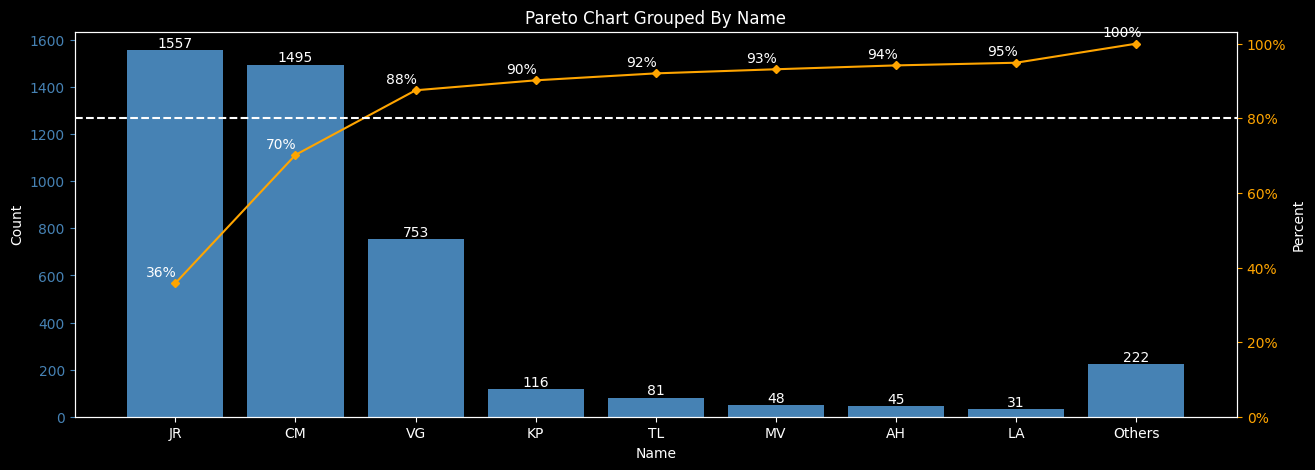

In [520]:
df_grouped_name = group_count(ridership_df_clean,"name",30)
pareto_chart(df_grouped_name)

Pickup and/or Dropoff Stop Pareto Chart

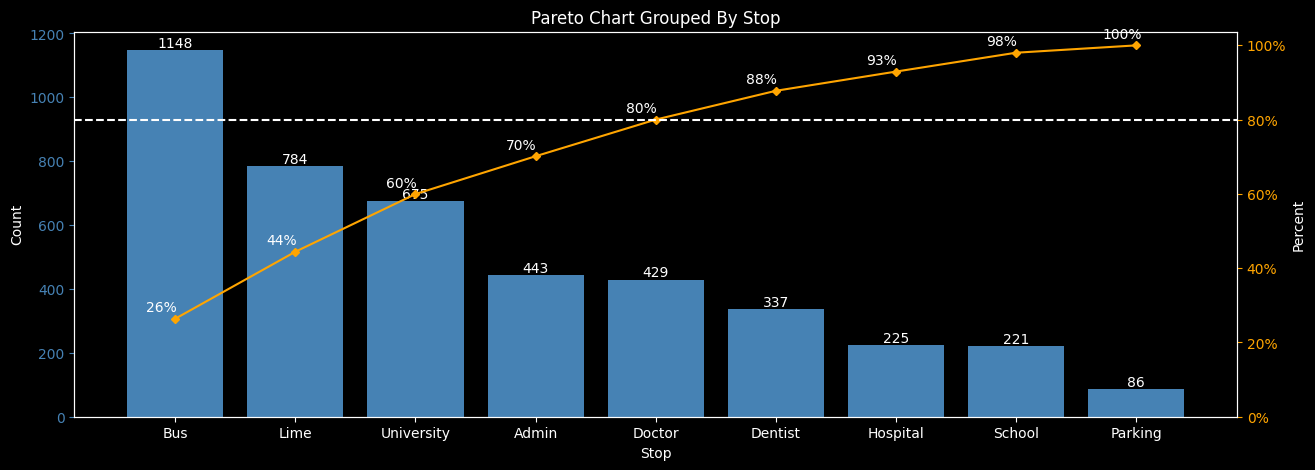

In [521]:
df_grouped_stop = group_count(ridership_df_clean,"stop")
pareto_chart(df_grouped_stop)

Vehicle Pareto Chart

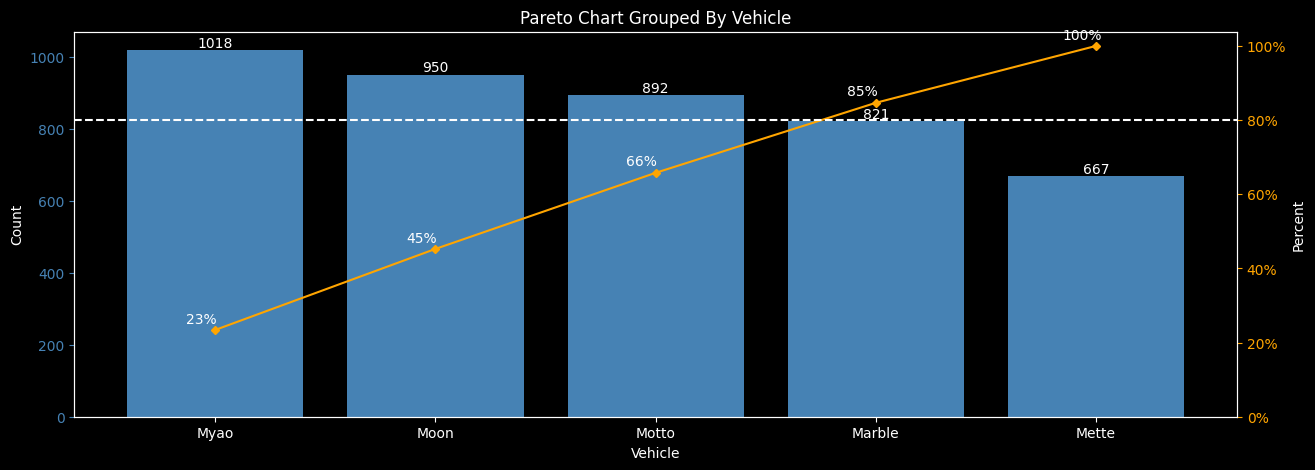

In [522]:
df_grouped_vehicle = group_count(ridership_df_clean,"vehicle")
pareto_chart(df_grouped_vehicle)

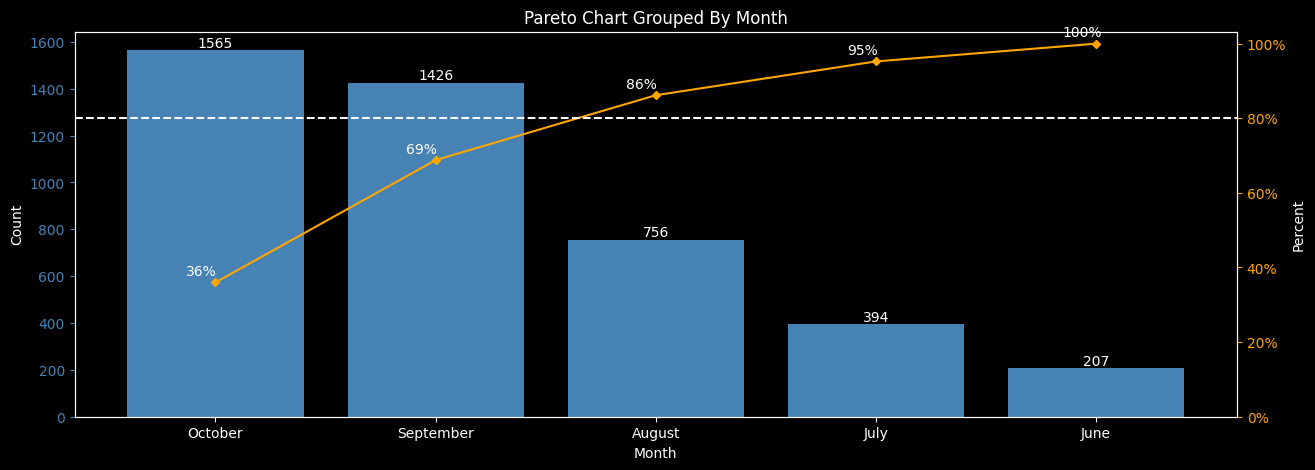

In [523]:
df_grouped_vehicle = group_count(ridership_df_clean,"month")
pareto_chart(df_grouped_vehicle)

## Histograms

Records per Hour Overall

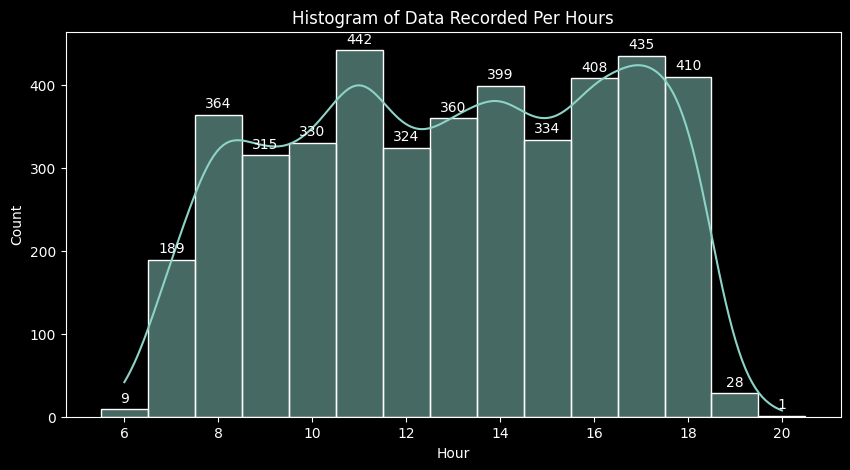

In [524]:
# plot records per hour
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data=ridership_df_clean, x="hour", kde=True)
ax.set_xlabel("Hour")
ax.set_ylabel("Count")
ax.set_title("Histogram of Data Recorded Per Hours")

# annotate barchart
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
        (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=10, xytext=(0, 8),
            textcoords='offset points')
    
plt.show()

Pickup and Dropoff by Number of People

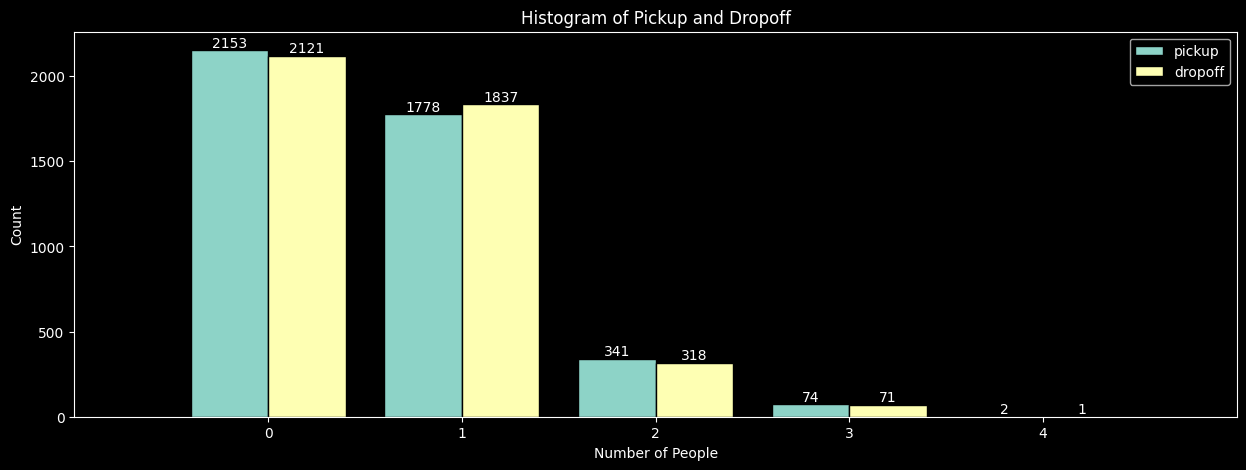

In [525]:
# plot histogram of dropoff and pickup
plot_histogram(ridership_df_clean,"pickup","dropoff")

## Big Histogram Analysis

Month and Day

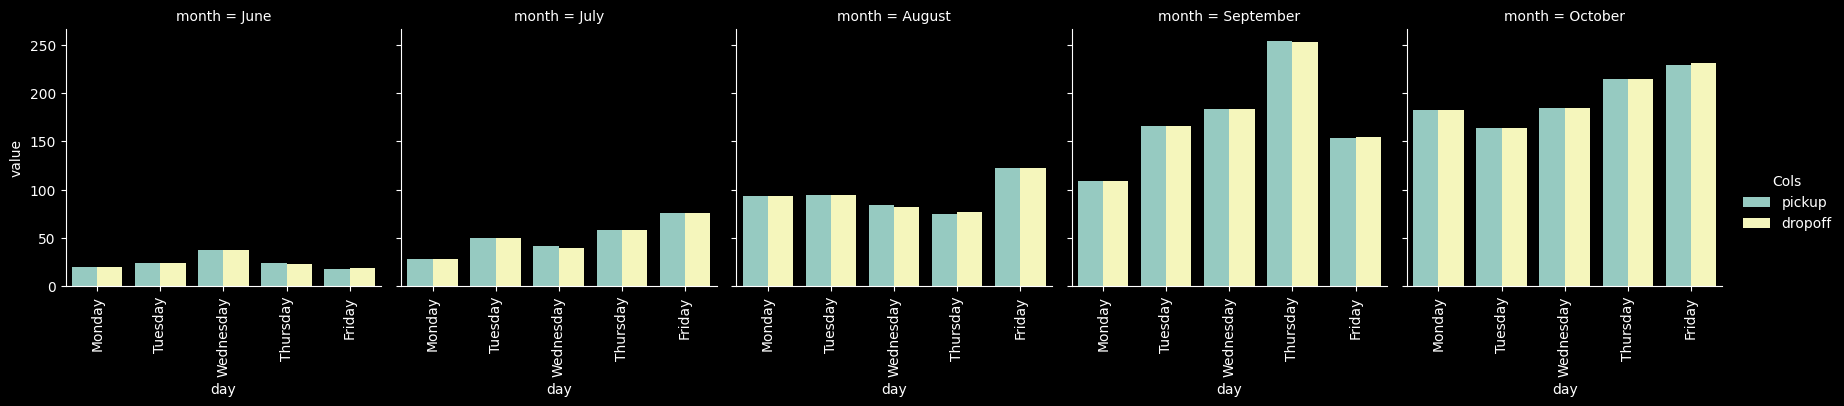

In [526]:
# plot month_day with pickup and dropoff
ridership_dfm_clean_month_day = ridership_df_clean[["month","day","pickup","dropoff"]].melt(id_vars=['day', 'month'],var_name="Cols")

g = sns.catplot(kind='bar', data=ridership_dfm_clean_month_day, col='month', x='day', y='value', hue='Cols', order=ridership_dfm_clean_month_day["day"].unique().sort_values(),
            col_order=ridership_dfm_clean_month_day["month"].unique().sort_values(), estimator=sum, errorbar=None, height=3.5)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    
plt.show()

Month, Day, and Hour

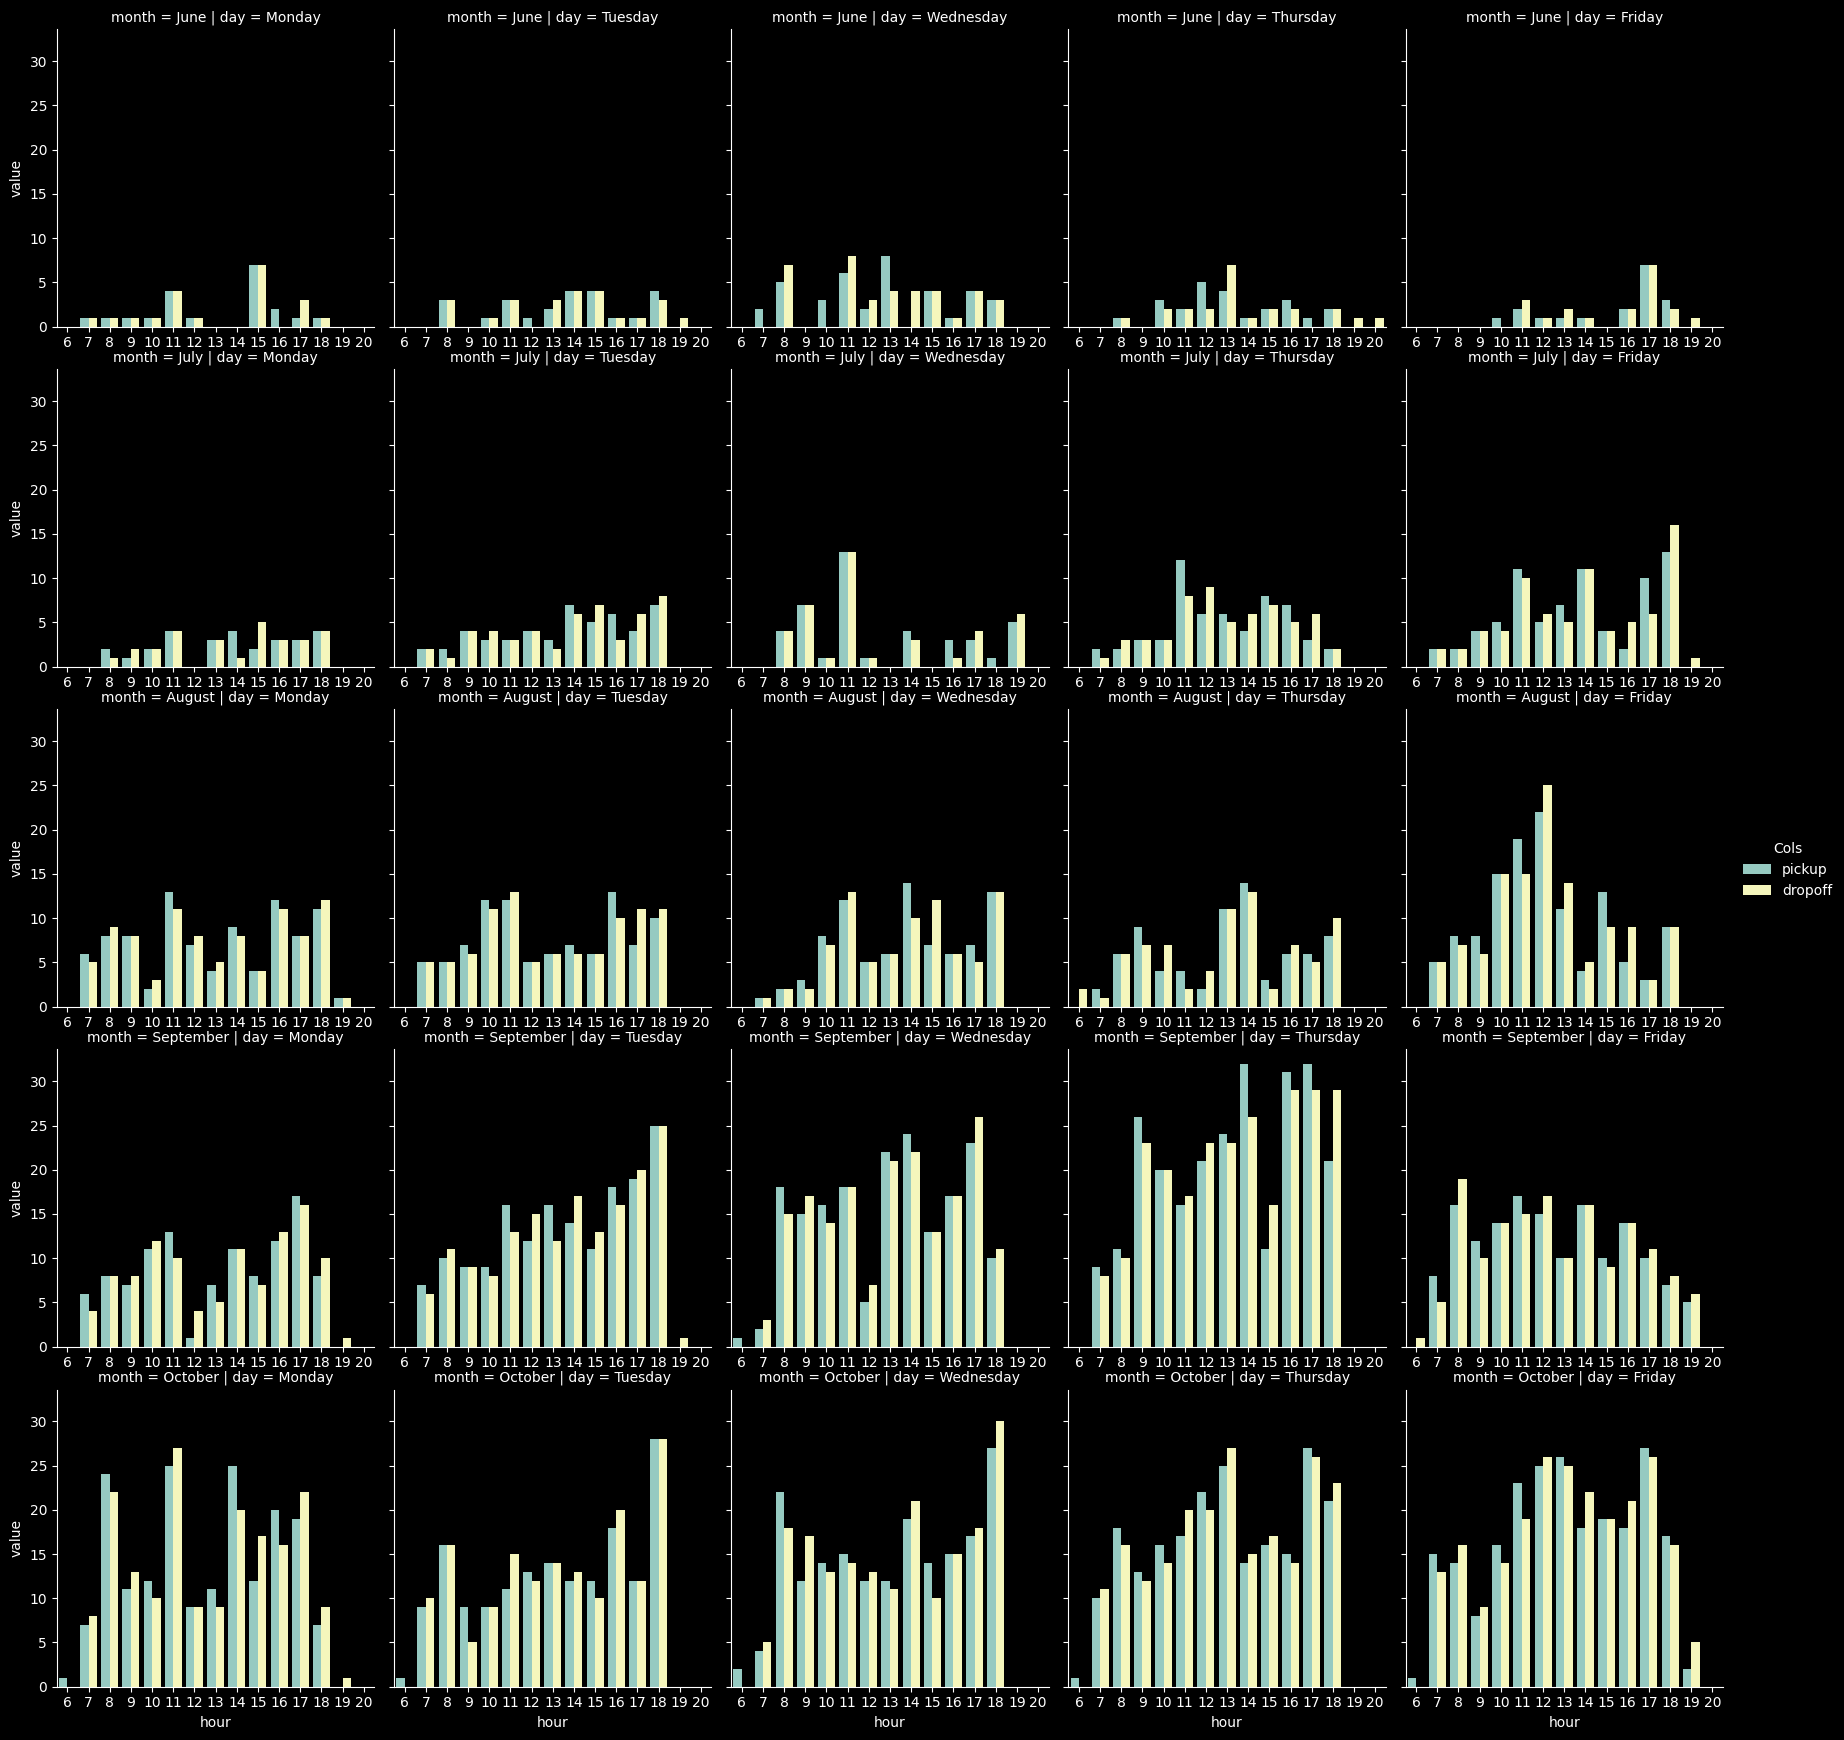

In [527]:
# plot month_day_hour with pickup and dropoff
ridership_dfm_clean_month_day_hour = ridership_df_clean[["month","day","hour","pickup","dropoff"]].melt(id_vars=["month", "day", "hour"],var_name="Cols")

# plot big histo
g = sns.catplot(kind='bar', data=ridership_dfm_clean_month_day_hour, row='month', col='day', x='hour', y='value', hue='Cols', col_order=ridership_dfm_clean_month_day_hour["day"].unique().sort_values(),
            row_order=ridership_dfm_clean_month_day_hour["month"].unique().sort_values(), estimator=sum, errorbar=None, height=3.5)

g.tick_params(labelbottom=True)

plt.show()

# Modeling Questions

Quick View of Cleaned Data

In [528]:
ridership_df_clean.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,month,day,hour,name
0,2021-06-03 13:08:10,1,0,Bus,Motto,13:05:00,2021-06-03,June,Thursday,13,JR
1,2021-06-03 13:31:41,0,1,Bus,Motto,13:31:43,2021-06-03,June,Thursday,13,JR
2,2021-06-04 11:06:02,1,0,School,Motto,11:03:00,2021-06-04,June,Friday,11,CM
3,2021-06-04 11:07:48,0,1,Bus,Motto,11:07:00,2021-06-04,June,Friday,11,CM
4,2021-06-04 12:43:54,1,0,Bus,Motto,12:40:00,2021-06-04,June,Friday,12,MN


## Machine Learning I

Prepare Data for Specific Modeling Questions

In [529]:
# group by day and then resplit month and day

# select max records because of ill matching pickup and dropoff
riders_per_day = ridership_df_clean.groupby(ridership_df_clean["date"]).sum(numeric_only=True).max(axis=1)
riders_per_day = riders_per_day.to_frame("riders")
riders_per_day.reset_index(inplace=True)

# get months
riders_per_day["month"] = riders_per_day["date"].dt.month_name()

# get days
riders_per_day["day"] = riders_per_day["date"].dt.day_name()

# get date as float64
riders_per_day["date_num"] = mdates.datestr2num(riders_per_day["date"].dt.strftime('%Y-%m-%d'))

riders_per_day.head()

,date,riders,month,day,date_num
0,2021-06-03,1,June,Thursday,"18,781.00"
1,2021-06-04,5,June,Friday,"18,782.00"
2,2021-06-07,2,June,Monday,"18,785.00"
3,2021-06-08,10,June,Tuesday,"18,786.00"
4,2021-06-09,4,June,Wednesday,"18,787.00"


### Plots

#### Box Plots

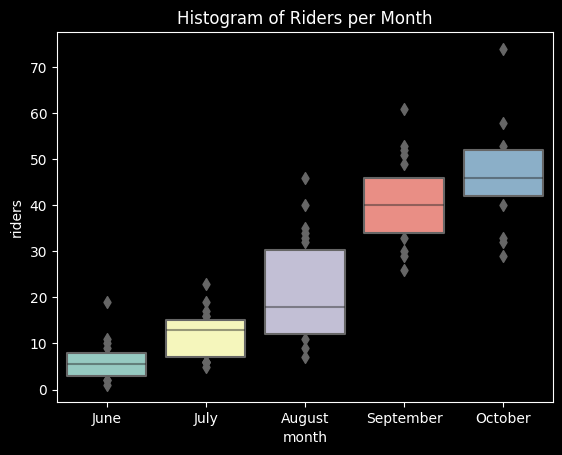

In [530]:
# box plots
sns.boxenplot(data=riders_per_day, x="month", y="riders")
plt.title("Histogram of Riders per Month")

plt.show()

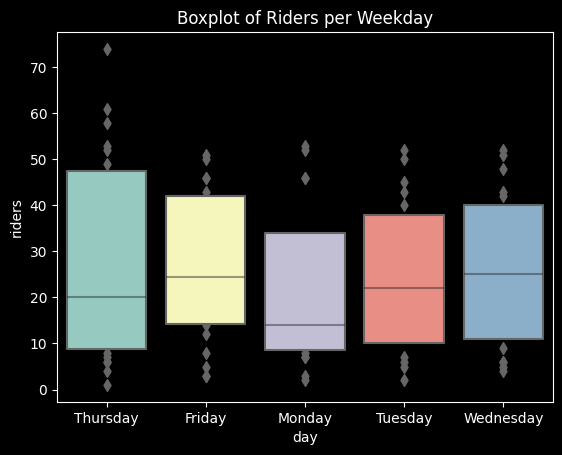

In [531]:
# box plots
sns.boxenplot(data=riders_per_day, x="day", y="riders")
plt.title("Boxplot of Riders per Weekday")

plt.show()

#### Regression Plot

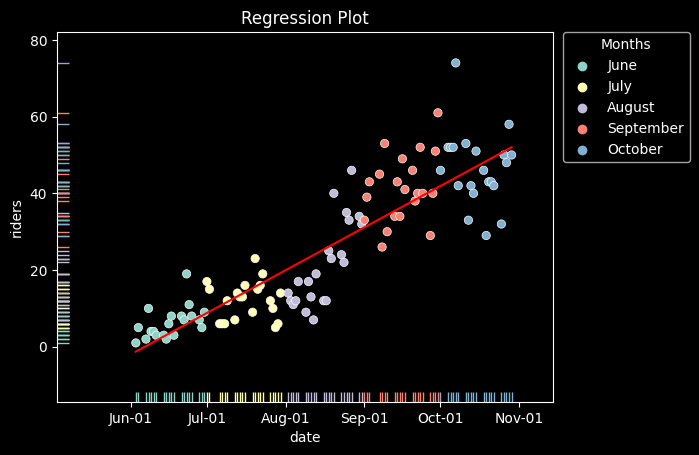

In [532]:
fig, ax = plt.subplots()
# plot scatter and rug
sns.scatterplot(data=riders_per_day, x="date", y="riders", hue="month", ax=ax)
sns.rugplot(data=riders_per_day, x="date", y="riders", hue="month", legend=None)

# get linear fit
x = riders_per_day["date_num"].to_numpy()
y = riders_per_day["riders"].to_numpy()
m, b = np.polyfit(x, y, 1)

# plot regression line
plt.plot(x, m*x+b, color='red')

# aesthetics
plt.title("Regression Plot")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,title="Months")
ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

plt.show()

#### Residual Plot

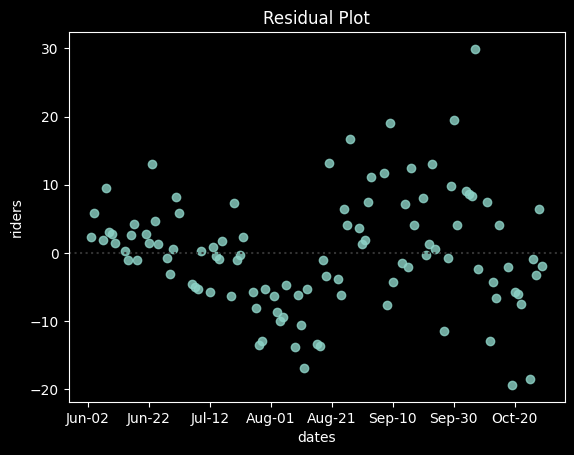

In [533]:
fig, ax = plt.subplots()
sns.residplot(data=riders_per_day, x="date_num", y="riders")
# regress date and riders:
ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))

ax.set_xlabel("dates")
ax.set_title("Residual Plot")
plt.show()

### One Hot Encode

In [534]:
# One Hot Encode 
features_one_hot_1 = pd.get_dummies(data=riders_per_day,columns=['day'])
features_one_hot_1["month"] = features_one_hot_1["date"].dt.month

features_one_hot_1.drop(columns=["date_num"],inplace=True)

print(features_one_hot_1.keys().tolist())
# features_one_hot_1 = features_one_hot_1.astype(np.float64)
colname_idx = features_one_hot_1.columns != 'date'

features_one_hot_1[features_one_hot_1.columns[colname_idx]] = features_one_hot_1.loc[:, colname_idx].astype(np.float64)
features_one_hot_1.head()

['date', 'riders', 'month', 'day_Friday', 'day_Monday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']


,date,riders,month,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday
0,2021-06-03,1.00,6.00,0.00,0.00,1.00,0.00,0.00
1,2021-06-04,5.00,6.00,1.00,0.00,0.00,0.00,0.00
2,2021-06-07,2.00,6.00,0.00,1.00,0.00,0.00,0.00
3,2021-06-08,10.00,6.00,0.00,0.00,0.00,1.00,0.00
4,2021-06-09,4.00,6.00,0.00,0.00,0.00,0.00,1.00


### Ridge ML

In [535]:
# use features_one_hot_1
y = np.asarray(features_one_hot_1['riders'])
X = np.asarray(features_one_hot_1.drop(["riders"],axis=1))
X[:,1:] = preprocessing.StandardScaler().fit_transform(X[:,1:])

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set shape: {X_train[:,1:].shape},  {y_train.shape}')
print(f'Test set shape:  {X_test[:,1:].shape},  {y_test.shape}')

# Grid Search
parameters = [{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}]
Grid = GridSearchCV(Ridge(), parameters, cv=4)
Grid.fit(X_train[:,1:],y_train)
y_hat = Grid.predict(X_test[:,1:])

# fprint Values
print(f"Best estimator: {Grid.best_estimator_}")
print(f"Tuned hyperparameters: (best parameter) {Grid.best_params_}")
print(f"Score for Test Set:   {Grid.best_estimator_.score(X_test[:,1:],y_test):.2%}")
print(f"Score for Train Set:  {Grid.best_estimator_.score(X_train[:,1:],y_train):.2%}")
print(f"Total Accuracy:       {Grid.best_score_:.2%}")

Train set shape: (84, 6),  (84,)
Test set shape:  (21, 6),  (21,)
Best estimator: Ridge(alpha=5)
Tuned hyperparameters: (best parameter) {'alpha': 5}
Score for Test Set:   85.62%
Score for Train Set:  75.12%
Total Accuracy:       67.18%


Scatter Plot with Trained Data

In [536]:
lm_df_1 = pd.DataFrame(
    {"date":X_test[:,0],
     "y_test":y_test,
     "y_hat":y_hat}
)

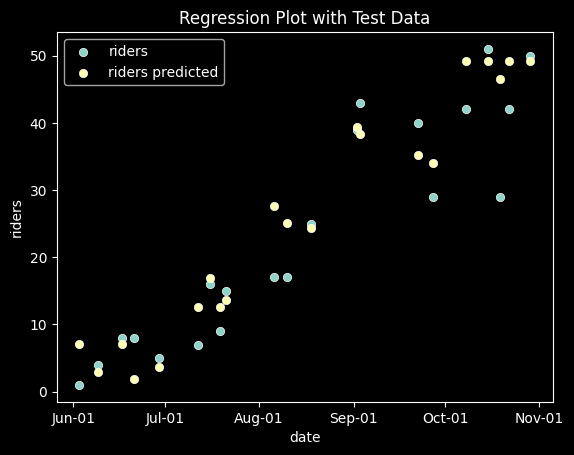

In [537]:
fig, ax = plt.subplots()

# scatter plots
sns.scatterplot(data=lm_df_1, x="date", y="y_test", ax=ax)
sns.scatterplot(data=lm_df_1, x="date", y="y_hat", ax=ax)

# aesthetics
plt.title("Regression Plot with Test Data")
plt.ylabel("riders")
plt.legend(["riders","riders predicted"])
ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))
 
# plot
plt.show()

Train with All Data to Predict New Values

In [538]:
# use best alpha
RigeModel_1 = Ridge(**Grid.best_params_)
RigeModel_1.fit(X[:,1:],y)
print(f"Score: {RigeModel_1.score(X[:,1:],y):.2%}")

Score: 76.99%


Prediction of Data Wanted

In [539]:
date_want = pd.date_range(start="2021-11-15", end="2021-11-21")

wanted_pred_df_1 = pd.DataFrame({
    "date":date_want,
    "month":date_want.strftime("%m"),
    "day":date_want.strftime("%A")
})

# One Hot Encode 
wanted_pred_df_1 = pd.get_dummies(data=wanted_pred_df_1,columns=['day'])
wanted_pred_df_1.drop(columns=["day_Saturday","day_Sunday"],inplace=True)

colname_idx = wanted_pred_df_1.columns != 'date'

wanted_pred_df_1[wanted_pred_df_1.columns[colname_idx]] = wanted_pred_df_1.loc[:, colname_idx].astype(np.float64)
wanted_pred_df_1.head()

# get X_predictor
X_pred = np.asarray(wanted_pred_df_1)
X_pred[:,1:] = preprocessing.StandardScaler().fit_transform(X_pred[:,1:])

# predict
yhat = RigeModel_1.predict(X_pred[:,1:])

# shouldn't have rides on the weekend...
# should be around an average of 55-60 riders a day...
output_df_1 = pd.concat([wanted_pred_df_1["date"],pd.DataFrame(yhat.round())],axis=1)
output_df_1.columns = ["date","riders"]

# save out to deliverables
output_df_1.to_csv(index=False,path_or_buf="deliverables/riders.csv")

# print df
output_df_1

,date,riders
0,2021-11-15,23.00
1,2021-11-16,24.00
2,2021-11-17,25.00
3,2021-11-18,29.00
4,2021-11-19,27.00
5,2021-11-20,26.00
6,2021-11-21,26.00


## Machine Learning II

### Dropoff Stop Pareto Chart

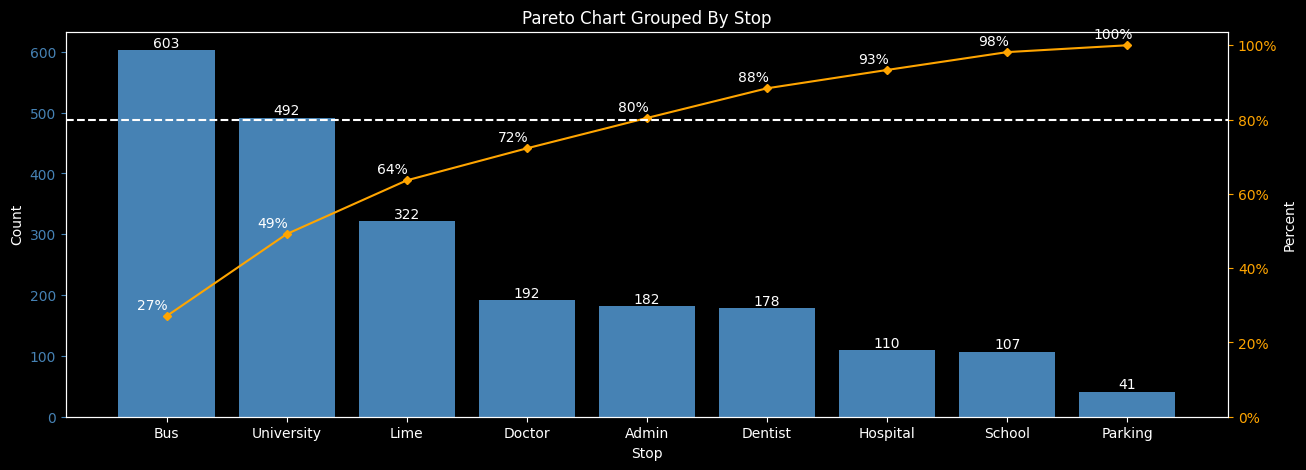

In [540]:
# select records that only have dropoffs
ridership_df_clean_dropoff = ridership_df_clean[ridership_df_clean["dropoff"] > 0]

# plot on Pareto Chart
df_grouped_stop = group_count(ridership_df_clean_dropoff,"stop")
pareto_chart(df_grouped_stop)

Expect 72% of the predicted stops to be: (ordered in Descending percent):

1. Bus
1. University
1. Lime
1. Docter

In [541]:
pickups_df.head()

,row_id,timestamp,pickup,dropoff,stop,vehicle,time,date,name
0,1,2021-11-01 07:10:54,1,0,Bus,Marble,07:00:00,2021-11-01,ES
1,2,2021-11-01 07:51:13,1,0,Bus,Marble,07:50:00,2021-11-01,ES
2,3,2021-11-01 08:02:13,1,0,Lime,Marble,08:01:00,2021-11-01,ES
3,4,2021-11-01 08:41:16,1,0,Doctor,Motto,08:41:00,2021-11-01,CM
4,5,2021-11-01 09:24:10,1,0,Bus,Myao,09:22:00,2021-11-01,CM


### One-Hot Encoding

In [542]:
features_2 = ridership_df_clean[["pickup","dropoff", 'day', 'hour', 'stop']]
features_2.head()

,pickup,dropoff,day,hour,stop
0,1,0,Thursday,13,Bus
1,0,1,Thursday,13,Bus
2,1,0,Friday,11,School
3,0,1,Friday,11,Bus
4,1,0,Friday,12,Bus


In [543]:
features_one_hot_2 = pd.get_dummies(data=features_2,columns=['day', 'hour', 'stop'])
print(features_one_hot_2.keys().tolist())
features_one_hot_2 = features_one_hot_2.astype('float64')
features_one_hot_2 = pd.concat([features_2["stop"],features_one_hot_2],axis=1)
features_one_hot_2.head()

['pickup', 'dropoff', 'day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Friday', 'day_Saturday', 'day_Sunday', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'stop_Admin', 'stop_Bus', 'stop_Dentist', 'stop_Doctor', 'stop_Hospital', 'stop_Lime', 'stop_Parking', 'stop_School', 'stop_University']


,stop,pickup,dropoff,day_Monday,day_Tuesday,day_Wednesday,day_Thursday,day_Friday,day_Saturday,day_Sunday,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,stop_Admin,stop_Bus,stop_Dentist,stop_Doctor,stop_Hospital,stop_Lime,stop_Parking,stop_School,stop_University
0,Bus,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Bus,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,School,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,Bus,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Bus,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [544]:
# use features_one_hot_2
y = np.asarray(features_one_hot_2["stop"])
X = np.asarray(features_one_hot_2.drop(["stop","dropoff"],axis=1))
X = preprocessing.StandardScaler().fit_transform(X)

In [545]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Train set shape: {X_train.shape},  {y_train.shape}')
print(f'Test set shape:  {X_test.shape},  {y_test.shape}')

Train set shape: (2913, 32),  (2913,)
Test set shape:  (1435, 32),  (1435,)


In [546]:
# init parameters
parameters = {'kernel':('linear', 'rbf', 'poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

svm = SVC()
svm_cv = GridSearchCV(svm,parameters,cv=10) # Grid Search

svm_cv.fit(X_train,y_train) # fit model

y_hat = svm_cv.predict(X_test) # predict test

# fprint Values
print(f"Best estimator: {svm_cv.best_estimator_}")
print(f"Tuned hyperparameters: (best parameter) {svm_cv.best_params_}")
print(f"Score for Test Set:   {svm_cv.best_estimator_.score(X_test ,y_test):.2%}")
print(f"Score for Train Set:  {svm_cv.best_estimator_.score(X_train,y_train):.2%}")
print(f"Total Accuracy:       {svm_cv.best_score_:.2%}")

Best estimator: SVC(C=0.001, gamma=0.001, kernel='linear')
Tuned hyperparameters: (best parameter) {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
Score for Test Set:   100.00%
Score for Train Set:  100.00%
Total Accuracy:       100.00%


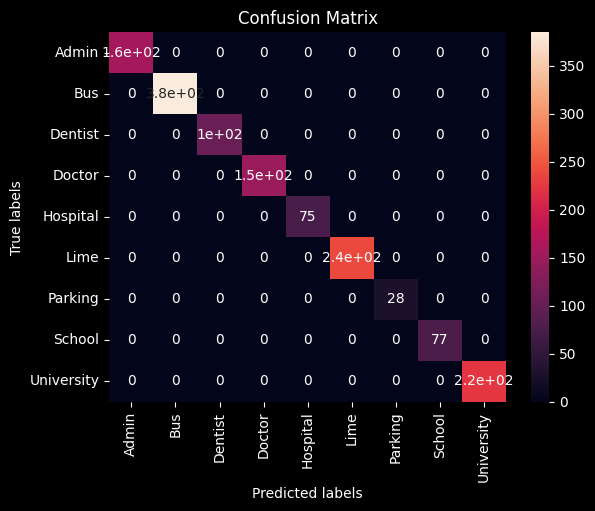

In [547]:
plot_confusion_matrix(y_test,y_hat)

In [548]:
# fit with whole model
svm = SVC(**svm_cv.best_params_)
svm.fit(X,y) # fit full model

SVC(C=0.001, gamma=0.001, kernel='linear')

In [ ]:
# mimic input data set
weekday = pickups_df["timestamp"].dt.day_name()
hour    = pickups_df["timestamp"].dt.hour
stop    = pickups_df["stop"]

pickups_pre_df = pickups_df.drop(["timestamp","vehicle","time","date","name","stop"],axis=1)

pickups_pre_df["day"] = weekday
pickups_pre_df["hour"] = hour
pickups_pre_df["stop"] = stop

# one hot encode
features_pred_3 = pd.get_dummies(data=pickups_pre_df,columns=['day', 'hour', 'stop'])
print(features_pred_3.keys().tolist())
features_pred_3["hour_20"] = 0
features_pred_3 = features_pred_3.astype('float64')
features_pred_3.head()
idx_order = ["row_id", 'pickup', 'dropoff', 'day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Friday', 'day_Saturday', 'day_Sunday', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'stop_Admin', 'stop_Bus', 'stop_Dentist', 'stop_Doctor', 'stop_Hospital', 'stop_Lime', 'stop_Parking', 'stop_School', 'stop_University']
features_pred_3 = features_pred_3[idx_order]

# predict
X_pred = np.asarray(features_pred_3.drop(["dropoff"],axis=1))
X_pred[:,1:] = preprocessing.StandardScaler().fit_transform(X_pred[:,1:])
y_hat = svm_cv.predict(X_pred[:,1:]) # predict

# shouldn't have rides on the weekend...
# should be matching predicted dropoffs from pareto chart


output_df_2 = pd.concat([X_pred["row_id"],pd.DataFrame(yhat)],axis=1)
output_df_2.columns = ["row_id","dropoff_stop"]

# save out to deliverables
output_df_2.to_csv(index=False,path_or_buf="deliverables/dropoff.csv")

# print df
output_df_2